# Lab2: MLPs and Dropout

First, let's load the data as before.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/LAP/Subjects/DL/labs

/content/drive/MyDrive/LAP/Subjects/DL/labs


In [4]:
# Load the data
import re
import random

# Let's do 2-way positive/negative classification instead of 5-way    
def load_sst_data(path,
                  easy_label_map={0:0, 1:0, 2:None, 3:1, 4:1}):
    data = []
    with open(path) as f:
        for i, line in enumerate(f): 
            example = {}
            example['label'] = easy_label_map[int(line[1])]
            if example['label'] is None:
                continue
            
            # Strip out the parse information and the phrase labels--
            # ---we don't need those here
            text = re.sub(r'\s*(\(\d)|(\))\s*', '', line)
            example['text'] = text[1:]
            data.append(example)
    random.seed(1)
    random.shuffle(data)
    return data

sst_home = '../data/trees/'
training_set = load_sst_data(sst_home + 'train.txt')
dev_set = load_sst_data(sst_home + 'dev.txt')
test_set = load_sst_data(sst_home + 'test.txt')

print('Training size: {}'.format(len(training_set)))
print('Dev size: {}'.format(len(dev_set)))
print('Test size: {}'.format(len(test_set)))

Training size: 6920
Dev size: 872
Test size: 1821


And extract bag-of-words feature vectors. For speed, we'll only use words that appear at least 10 times in the training set, leaving us with $|V|=1254$.

In [5]:
import collections
import numpy as np

def feature_function(datasets):
    '''Annotates datasets with feature vectors.'''
    
    # Extract vocabulary
    def tokenize(string):
        return string.split()
    
    word_counter = collections.Counter()
    for example in datasets[0]:
        word_counter.update(tokenize(example['text']))
    
    vocabulary = set([word for word in word_counter if word_counter[word] > 10])
                                
    feature_names = set()
    for i, dataset in enumerate(datasets):
        for example in dataset:
            example['features'] = collections.defaultdict(float)
            
            # Extract features (by name) for one example
            word_counter = collections.Counter(tokenize(example['text']))
            for x in word_counter.items():
                if x[0] in vocabulary:
                    example["features"]["word_count_for_" + x[0]] = x[1]
            
            feature_names.update(example['features'].keys())
                            
    # By now, we know what all the features will be, so we can
    # assign indices to them.
    feature_indices = dict(zip(feature_names, range(len(feature_names))))
    indices_to_features = {v: k for k, v in feature_indices.items()}
    dim = len(feature_indices)
                
    # Now we create actual vectors from those indices.
    for dataset in datasets:
        for example in dataset:
            example['vector'] = np.zeros((dim))
            for feature in example['features']:
                example['vector'][feature_indices[feature]] = example['features'][feature]
    return indices_to_features, dim
    
indices_to_features, dim = feature_function([training_set, dev_set, test_set])

print('Vocabulary size: {}'.format(dim))

Vocabulary size: 1254


And define a batch evalution function.

In [6]:
def evaluate_classifier(classifier, eval_set):
    correct = 0
    hypotheses = classifier(eval_set)
    for i, example in enumerate(eval_set):
        hypothesis = hypotheses[i]
        if hypothesis == example['label']:
            correct += 1        
    return correct / float(len(eval_set))

## Assignments

Now for the fun part! The below should be a working implementation of logistic regression in TensorFlow.

### Part One:

Modify it to turn it into an MLP with two ReLU hidden layers of 50 dimensions.

Keep in mind that initializing weight matrices with zeros causes problems in deep neural networks trained by SGD. (Why?) You should use tf.random.normal instead, with stddev=0.1.

If your model works, it should be able to overfit, reaching about 90% accuracy *on the training set* in the first 100 epochs.

### Part Two:

After each hidden layer, add dropout with a 80% keep rate (20% of drop rate). You're welcome to use `tf.nn.dropout`.

Remember that dropout behaves differently at training time and at test time. This is not automatic. You can implement in various ways, but an easy way can be this:

- Hint: Treat the dropout rate as an input to the model, just like `x`. At training time, feed it a value of `0.2`, at test time, feed it a value of `0.0`. You can explore different dropout values.

If dropout works, your model should overfit less, but should still perform about as well (or, hopefully, better) on the dev set.

In [7]:
%tensorflow_version 2.x
import tensorflow as tf
tf.__version__

'2.7.0'

In [49]:
class mlp_classifier:
    def __init__(self, dim, lr=0.3, ep=100, size=50, dr=0.2):
        # Define the hyperparameters
        self.learning_rate = lr  # Should be about right
        self.training_epochs = ep  # How long to train for - chosen to fit within class time
        self.display_epoch_freq = 1  # How often to test and print out statistics
        self.dim = dim  # The number of features
        self.batch_size = 256  # Somewhat arbitrary - can be tuned, but often tune for speed, not accuracy
        
        # TODO: Use these.
        self.hidden_layer_sizes = [size, size]
        self.rate = dr

        self.trainable_variables = []
        # Define (most of) the model
        '''Variables'''
        self.W0 = tf.Variable(tf.random.normal([self.dim, self.hidden_layer_sizes[0]], stddev=0.1), dtype='float32')
        self.W1 = tf.Variable(tf.random.normal([self.hidden_layer_sizes[0], self.hidden_layer_sizes[1]], stddev=0.1), dtype='float32')
        self.W2 = tf.Variable(tf.random.normal([self.hidden_layer_sizes[1], 2], stddev=0.1), dtype='float32')
        self.b0 = tf.Variable(tf.random.normal([self.hidden_layer_sizes[0]], stddev=0.1), dtype='float32')
        self.b1 = tf.Variable(tf.random.normal([self.hidden_layer_sizes[1]], stddev=0.1), dtype='float32')
        self.b2 = tf.Variable(tf.random.normal([2], stddev=0.1), dtype='float32')
        self.trainable_variables.append(self.W0)
        self.trainable_variables.append(self.W1)
        self.trainable_variables.append(self.W2)
        self.trainable_variables.append(self.b0)
        self.trainable_variables.append(self.b1)
        self.trainable_variables.append(self.b2)

    def model(self, x, rate):
        '''Training Computation'''
        h0 = tf.nn.relu(tf.matmul(x, self.W0) + self.b0)
        d0 = tf.nn.dropout(h0, rate)
        h1 = tf.nn.relu(tf.matmul(d0, self.W1) + self.b1)
        d1 = tf.nn.dropout(h1, rate)
        logits = tf.matmul(d1, self.W2) + self.b2
        return logits
     

    def train(self, training_data, dev_set):
        def get_minibatch(dataset, start_index, end_index):
            indices = range(start_index, end_index)
            vectors = np.float32(np.vstack([dataset[i]['vector'] for i in indices]))
            labels = [dataset[i]['label'] for i in indices]
            return vectors, labels
      
        print ('Training.')
  
        dev_accs = []
        train_accs = []
        costs = []

        # Training cycle
        for epoch in range(self.training_epochs):
            random.shuffle(training_set)
            avg_cost = 0.
            total_batch = int(len(training_set) / self.batch_size)
            # Loop over all batches in epoch
            for i in range(total_batch):
                # Assemble a minibatch of the next B examples
                minibatch_vectors, minibatch_labels = get_minibatch(training_set, 
                                                                    self.batch_size * i, 
                                                                    self.batch_size * (i + 1))
                # Run the optimizer to take a gradient step, and also fetch the value of the 
                # cost function for logging
                with tf.GradientTape() as tape:
                  logits = self.model(minibatch_vectors, self.rate)
                  # Define the cost function (here, the exp and sum are built in)
                  cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=minibatch_labels))
                gradients = tape.gradient(cost, self.trainable_variables)
                optimizer = tf.optimizers.SGD(self.learning_rate)
                optimizer.apply_gradients(zip(gradients, self.trainable_variables))
                # Compute average loss
                avg_cost += cost / total_batch
                
            # Display some statistics about the step
            if (epoch+1) % self.display_epoch_freq == 0:
                dev_acc = evaluate_classifier(self.classify, dev_set[0:500])
                train_acc = evaluate_classifier(self.classify, training_set[0:500])
                tf.print("Epoch:", (epoch+1), "Cost:", avg_cost,
                      "Dev acc:", dev_acc, 
                      "Train acc:", train_acc)
                costs.append(avg_cost)
                dev_accs.append(dev_acc)
                train_accs.append(train_acc)

        return costs, dev_accs, train_accs
    
    def classify(self, examples):
        # This classifies a list of examples
        vectors = np.float32(np.vstack([example['vector'] for example in examples]))
        logits = self.model(vectors, 0)
        return np.argmax(logits, axis=1)

In [38]:
import matplotlib.pyplot as plt
def plot_learning_curves(cost, dev_acc, train_acc):
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(dev_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')
    plt.subplot(2, 1, 2)
    plt.plot(cost, label='Training Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.title('Training Loss')
    plt.xlabel('epoch')
    plt.show()

## Part One

Now let's train it.

In [43]:
classifier = mlp_classifier(dim, dr=0.0)
cost, dev_acc, train_acc = classifier.train(training_set, dev_set)

Training.
Epoch: 1 Cost: 0.689846933 Dev acc: 0.568 Train acc: 0.55
Epoch: 2 Cost: 0.682082057 Dev acc: 0.612 Train acc: 0.594
Epoch: 3 Cost: 0.673014522 Dev acc: 0.618 Train acc: 0.6
Epoch: 4 Cost: 0.662286341 Dev acc: 0.598 Train acc: 0.614
Epoch: 5 Cost: 0.648621142 Dev acc: 0.66 Train acc: 0.682
Epoch: 6 Cost: 0.632515252 Dev acc: 0.678 Train acc: 0.7
Epoch: 7 Cost: 0.620798409 Dev acc: 0.672 Train acc: 0.658
Epoch: 8 Cost: 0.611190259 Dev acc: 0.676 Train acc: 0.648
Epoch: 9 Cost: 0.595699847 Dev acc: 0.65 Train acc: 0.644
Epoch: 10 Cost: 0.578076065 Dev acc: 0.692 Train acc: 0.736
Epoch: 11 Cost: 0.571401477 Dev acc: 0.718 Train acc: 0.712
Epoch: 12 Cost: 0.566174626 Dev acc: 0.668 Train acc: 0.662
Epoch: 13 Cost: 0.551242 Dev acc: 0.688 Train acc: 0.716
Epoch: 14 Cost: 0.548275232 Dev acc: 0.75 Train acc: 0.792
Epoch: 15 Cost: 0.53343 Dev acc: 0.754 Train acc: 0.798
Epoch: 16 Cost: 0.532097042 Dev acc: 0.742 Train acc: 0.798
Epoch: 17 Cost: 0.51987648 Dev acc: 0.744 Train acc: 0

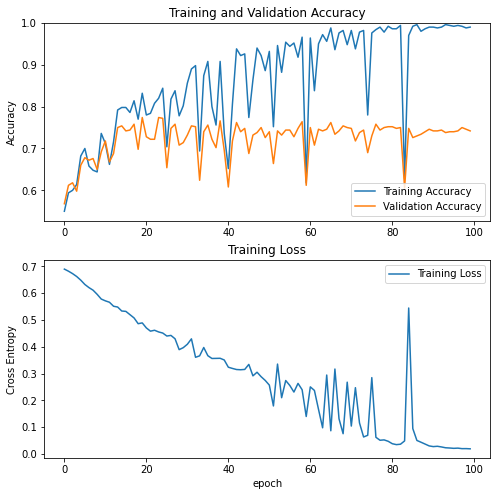

In [44]:
plot_learning_curves(cost, dev_acc, train_acc)

And evaluate it.

In [45]:
evaluate_classifier(classifier.classify, test_set)

0.7440966501922021

## Part Two

Now let's train it.

In [46]:
classifier = mlp_classifier(dim, dr=0.0)
cost, dev_acc, train_acc = classifier.train(training_set, dev_set)

Training.
Epoch: 1 Cost: 0.689357519 Dev acc: 0.554 Train acc: 0.502
Epoch: 2 Cost: 0.680496454 Dev acc: 0.6 Train acc: 0.562
Epoch: 3 Cost: 0.669431746 Dev acc: 0.62 Train acc: 0.61
Epoch: 4 Cost: 0.658512294 Dev acc: 0.646 Train acc: 0.614
Epoch: 5 Cost: 0.642958641 Dev acc: 0.662 Train acc: 0.626
Epoch: 6 Cost: 0.631130517 Dev acc: 0.644 Train acc: 0.636
Epoch: 7 Cost: 0.613936543 Dev acc: 0.584 Train acc: 0.564
Epoch: 8 Cost: 0.608273387 Dev acc: 0.714 Train acc: 0.706
Epoch: 9 Cost: 0.587861 Dev acc: 0.598 Train acc: 0.566
Epoch: 10 Cost: 0.583866894 Dev acc: 0.716 Train acc: 0.74
Epoch: 11 Cost: 0.562672436 Dev acc: 0.698 Train acc: 0.714
Epoch: 12 Cost: 0.553086042 Dev acc: 0.69 Train acc: 0.736
Epoch: 13 Cost: 0.54630971 Dev acc: 0.708 Train acc: 0.754
Epoch: 14 Cost: 0.541042864 Dev acc: 0.712 Train acc: 0.722
Epoch: 15 Cost: 0.530879259 Dev acc: 0.662 Train acc: 0.716
Epoch: 16 Cost: 0.505131125 Dev acc: 0.768 Train acc: 0.792
Epoch: 17 Cost: 0.528431475 Dev acc: 0.698 Train 

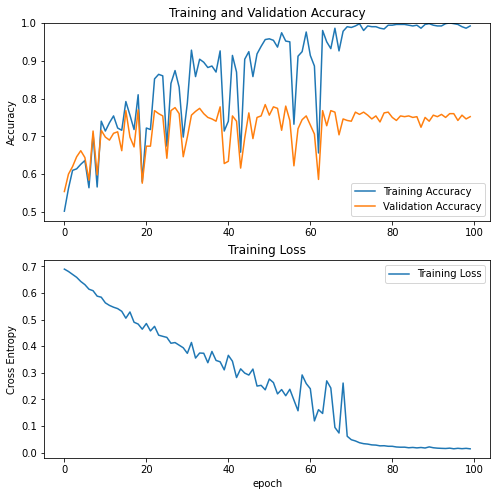

In [47]:
plot_learning_curves(cost, dev_acc, train_acc)

And evaluate it.

In [48]:
evaluate_classifier(classifier.classify, test_set)

0.7380560131795717

## Parameter tuning

In [55]:
import numpy as np
import matplotlib.pyplot as plt


def plot_learning_curve(par_values, train_scores, dev_scores, title ="Train-Dev Learning Curve", ylim=None, xlab="Learning rate", ylab="Accuracy"):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    par_values : list of checked values of the current parameter.
    
    train_scores : list of scores obtained in training set (same length as par_values).
    
    test_scores : list of scores obtained in dev set (same length as par_values)
    
    title : string
        Title for the chart.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel(xlab)
    plt.ylabel(ylab)

    plt.grid()

    plt.plot(par_values, train_scores, 'o-', color="r",
             label="Training score")
    plt.plot(par_values, dev_scores, 'o-', color="g",
             label="Dev score")

    plt.legend(loc="best")
    return plt

In [53]:
lrs = [0.1, 0.2, 0.3]
dr = 0.2
ep = 100
train_acc = []
dev_acc = []
max_dev_acc = 0.0
for lr in lrs:
    print("[Checking] Learning rate: {}".format(lr))
    classifier = mlp_classifier(dim, lr=lr, dr=dr, ep=ep)
    classifier.train(training_set, dev_set)
    train = evaluate_classifier(classifier.classify, training_set)
    dev = evaluate_classifier(classifier.classify, dev_set)
    train_acc.append(train)
    dev_acc.append(dev)
    
    if max_dev_acc < dev:
        max_dev_acc= dev
        max_dev_lr=lr
    
    print("[Result] lr: {}, Training acc: {}, Dev acc: {}\n".format(lr, train, dev))
print("[Best result] lr: {}, Dev acc: {}".format(max_dev_lr,max_dev_acc))

[Checking] Learning rate: 0.1
Training.
Epoch: 1 Cost: 0.694744885 Dev acc: 0.488 Train acc: 0.502
Epoch: 2 Cost: 0.693065703 Dev acc: 0.524 Train acc: 0.556
Epoch: 3 Cost: 0.691847801 Dev acc: 0.532 Train acc: 0.558
Epoch: 4 Cost: 0.690175951 Dev acc: 0.542 Train acc: 0.58
Epoch: 5 Cost: 0.688598037 Dev acc: 0.55 Train acc: 0.53
Epoch: 6 Cost: 0.688172936 Dev acc: 0.548 Train acc: 0.548
Epoch: 7 Cost: 0.686652482 Dev acc: 0.55 Train acc: 0.506
Epoch: 8 Cost: 0.685695589 Dev acc: 0.548 Train acc: 0.584
Epoch: 9 Cost: 0.684864044 Dev acc: 0.556 Train acc: 0.534
Epoch: 10 Cost: 0.682640731 Dev acc: 0.558 Train acc: 0.576
Epoch: 11 Cost: 0.680721 Dev acc: 0.55 Train acc: 0.602
Epoch: 12 Cost: 0.676903844 Dev acc: 0.572 Train acc: 0.604
Epoch: 13 Cost: 0.676075041 Dev acc: 0.578 Train acc: 0.646
Epoch: 14 Cost: 0.672617555 Dev acc: 0.572 Train acc: 0.632
Epoch: 15 Cost: 0.668963552 Dev acc: 0.594 Train acc: 0.604
Epoch: 16 Cost: 0.666961 Dev acc: 0.61 Train acc: 0.576
Epoch: 17 Cost: 0.666

[0.1, 0.2, 0.3]
[0.938150289017341, 0.9895953757225433, 0.9539017341040462]
[0.7236238532110092, 0.7350917431192661, 0.694954128440367]


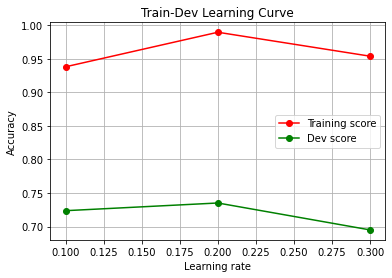

In [56]:
lc_lr = plot_learning_curve(lrs, train_acc, dev_acc)
print(lrs)
print(train_acc)
print(dev_acc)
lc_lr.show()

In [57]:
lr = 0.2
drs = [0.1, 0.2, 0.3]
ep = 100
train_acc = []
dev_acc = []
max_dev_acc = 0.0
for dr in drs:
    print("[Checking] Dropout rate: {}".format(lr))
    classifier = mlp_classifier(dim, lr=lr, dr=dr, ep=ep)
    classifier.train(training_set, dev_set)
    train = evaluate_classifier(classifier.classify, training_set)
    dev = evaluate_classifier(classifier.classify, dev_set)
    train_acc.append(train)
    dev_acc.append(dev)
    
    if max_dev_acc < dev:
        max_dev_acc= dev
        max_dev_dr=dr
    
    print("[Result] dr: {}, Training acc: {}, Dev acc: {}\n".format(dr, train, dev))
print("[Best result] dr: {}, Dev acc: {}".format(max_dev_dr,max_dev_acc))

[Checking] Dropout rate: 0.2
Training.
Epoch: 1 Cost: 0.69338125 Dev acc: 0.532 Train acc: 0.552
Epoch: 2 Cost: 0.689488411 Dev acc: 0.552 Train acc: 0.532
Epoch: 3 Cost: 0.686040759 Dev acc: 0.578 Train acc: 0.606
Epoch: 4 Cost: 0.681084275 Dev acc: 0.61 Train acc: 0.602
Epoch: 5 Cost: 0.676267087 Dev acc: 0.624 Train acc: 0.626
Epoch: 6 Cost: 0.670834541 Dev acc: 0.634 Train acc: 0.622
Epoch: 7 Cost: 0.664199054 Dev acc: 0.656 Train acc: 0.642
Epoch: 8 Cost: 0.655770421 Dev acc: 0.636 Train acc: 0.65
Epoch: 9 Cost: 0.646120667 Dev acc: 0.652 Train acc: 0.658
Epoch: 10 Cost: 0.636125743 Dev acc: 0.662 Train acc: 0.672
Epoch: 11 Cost: 0.628656149 Dev acc: 0.672 Train acc: 0.676
Epoch: 12 Cost: 0.619053543 Dev acc: 0.666 Train acc: 0.672
Epoch: 13 Cost: 0.605159819 Dev acc: 0.68 Train acc: 0.748
Epoch: 14 Cost: 0.590971768 Dev acc: 0.676 Train acc: 0.662
Epoch: 15 Cost: 0.576702535 Dev acc: 0.712 Train acc: 0.704
Epoch: 16 Cost: 0.566503048 Dev acc: 0.728 Train acc: 0.724
Epoch: 17 Cost

[0.1, 0.2, 0.3]
[0.9302023121387283, 0.9878612716763006, 0.9742774566473988]
[0.6995412844036697, 0.7419724770642202, 0.7075688073394495]


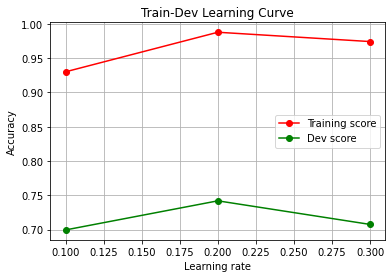

In [58]:
lc_dr = plot_learning_curve(drs, train_acc, dev_acc)
print(drs)
print(train_acc)
print(dev_acc)
lc_dr.show()

# Atribution:
Adapted by Oier Lopez de Lacalle, Olatz Perez de Viñaspre and Ander Barrena, based on a notebook by Sam Bowman at NYU